# Modelo SIR

## Imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from numba import jit

sns.set_theme()
sns.set_palette("colorblind")

## Funções de Simulação

Vamos usar interface parecida com a que usamos nas atividades do Modelo de Ising. Assim, a rede de autômatos será guardada num array de $N$ posições e a vizinhança será feita através de uma matriz.

In [106]:
@jit(nopython=True)
def neighbours(N, L):
    """
    Constrói a matriz de vizinhança.
    Assume que há uma "vizinhança circular" como se a rede 
    fosse um toro.
    Adaptação do algoritmo proposto no enunciado da atividade
    Wang-Landau
    """
    # Cria uma matriz Nx4
    viz = np.zeros((N,4), dtype=np.longlong)

    # (k,0): vizinho à direita
    # (k,1): vizinho acima
    # (k,2): vizinho à esquerda
    # (k,3): vizinho abaixo]
    for k in range(N):
        # Vizinho à direita (k,0)
        viz[k][0] = k+1
        if (k % L == L-1):
            # Sítio na borda da direita
            viz[k][0] = k+1-L

        # Vizinho acima (k,1)
        viz[k][1] = k+L
        if (k >= N-L):
            # Sítio na borda superior
            viz[k][1] = k+L-N

        # Vizinho à esquerda (k,2)
        viz[k][2] = k-1
        if (k % L == 0):
            # Sítio na borda da esquerda
            viz[k][2] = k+L-1

        # Vizinho abaixo (k,3)
        viz[k][3] = k-L
        if (k < L):
            # Sítio na borda inferior
            viz[k][3] = k+N-L
    return viz

Para propiciar estados iniciais, podemos criar uma função que infecta $k$ pessoas numa rede em que todas ainda estavam apenas suscetíveis.

In [4]:
@jit(nopython=True)
def random_infected(N, n_infected):
    """
    Gera um estado de epidemia com alguns sítios
    aleatórios considerados como infectados
    """
    # Gera N sítios suscetíveis
    # De 0 a N-1
    s = []
    for i in range(N):
        s.append(0)
    s = np.array(s)
    
    # Infecta n_infected sítios
    while (s.sum() < n_infected):
        i = np.random.randint(0, N)
        s[i] = 1
    return s

Finalmente, podemos simular a epidemia, usando as probabilidades de que um infectado contamine algum suscetível ($p_c$) e que um infectado se recupere ($p_r$).

In [5]:
@jit(nopython=True)
def count(s):
    """
    Conta quantos 0's, 1's e 2's tem no array
    
    Parâmetros:
        s: array com apenas 0,1 e 2
    Retorno:
        hist: tupla com quantidades de 0's, 1's e 2's, 
            respectivamente
    """
    hist = [0,0,0]
    for i in range(len(s)):
        hist[s[i]] += 1
    return hist

In [130]:
def simulate_epidemy(N, L, s, pc, pr, n_iter, prints=False, print_states=False):
    """
    Simula uma epidemia segundo o modelo SIR numa rede de
    N autômatos celulares, organizados de forma quadrada (LxL),
    e com vizinhança circular.
    
    Parâmetros:
        N: quantidade de autômatos celulares
        L: lado do quadrado da rede (N = L*L)
        s: estado inicial
        pc: probabilidade de contaminação
        pr: probabilidade de recuperação
        n_iter: quantidade de iterações
        prints: se verdadeiro, imprimirá resultados intermediários
    
    Retornos:
        suscp_t: lista com quantidade de suscetíveis a cada momento
        infec_t: lista com quantidade de infectados a cada momento
        recup_t: lista com quantidade de recuperados a cada momento
        ts: iterações
    """
    assert N == L**2
    viz = neighbours(N,L)

    
    suscp_t = []
    infec_t = []
    recup_t = []
    ts = []
    
    
    for n in range(n_iter):
        distribution = count(s)
        if (distribution[1] == 0):
            print("Não há mais infectados. Iteração: ", n)
            break
        
        if (n % 20 == 0 and print_states == True):
            plot_map(s, L, title=("Iteração "+str(n)))
            plt.show()
        elif (n % 20 == 0 and print_states == False):
            print("Iteração "+str(n))
        
        # Para cada autômato da rede
        for i in range(N):
            if (s[i] == 1):
                # Contaminada
                if (np.random.random() < pr):
                    # Chance de se recuperar
                    if (prints): print(i,"recuperado")
                    s[i] = 2
                else:
                    viz_k = viz[i]
                    for j in viz_k:
                        if (s[j] == 0):
                            if (np.random.random() < pc):
                                # Chance de contaminar a outra
                                if (prints): print(j,"contaminado por ", i)
                                s[j] = 1
            elif (s[i] == 2):
                # Recuperada
                pass
            else:
                # Suscetível
                pass
            
            distribution = count(s)
            suscp_t.append(distribution[0])
            infec_t.append(distribution[1])
            recup_t.append(distribution[2])
            ts.append(i)
    return suscp_t, infec_t, recup_t, ts

## Funções de Plotting

### Plot da Rede

In [125]:
from matplotlib.colors import LinearSegmentedColormap

def plot_map(s, L, title=None):
    # Transforma o vetor em matriz
    s1 = s.reshape(L,L)
    s2 = np.flip(s1,0)

    # Plot
    resize_factor = L/100
    base_factor = 3
    plt.figure(figsize=(base_factor*resize_factor,
                        base_factor*resize_factor))
    colors = ['b','r','g']
    cmap = LinearSegmentedColormap.from_list('cmap', colors, N=3)
    plt.imshow(s2, cmap=cmap)
    plt.grid(False)
    plt.xticks([],[])
    plt.yticks([],[])
    
    # Coloca título
    if (title is not None):
        plt.title(title)

In [7]:
def plot(N, s, title=None):
    """
    Plota a rede de autômatos celulares
    
    Parâmetros:
        N: tamanho da rede
        s: estado atual da rede
        title: (opcional) título a ser colocado acima no plot
    Retornos:
        None
    """
    fig, ax1 = plt.subplots(figsize=(6,6))

    # Suscetíveis em verde, 
    # Infectados em vermelho,
    # Recuperados em verde
    L = np.sqrt(N)
    i = 0
    j = 0
    for site in s:
        if (site == 0):
            plt.scatter(i, j, color='b',edgecolors='black',
                        linewidths=.5, s=150)
        elif (site == 1):
            plt.scatter(i, j, color='r',edgecolors='black',
                        linewidths=.5, s=150)
        elif (site == 2):
            plt.scatter(i, j, color='g',edgecolors='black',
                        linewidths=.5, s=150)
        else:
            print("Invalid")
        
        j += 1
        if (j % L == 0): 
            j = 0
            i += 1
            
    # Remove os ticks
    plt.xticks([], [])
    plt.yticks([], [])
    
    # Coloca título
    if (title is not None):
        plt.title(f"{title}")

In [ ]:
def plot(N, s, title=None):
    """
    Plota a rede de autômatos celulares
    
    Parâmetros:
        N: tamanho da rede
        s: estado atual da rede
        title: (opcional) título a ser colocado acima no plot
    Retornos:
        None
    """
    fig, ax1 = plt.subplots(figsize=(6,6))

    # Suscetíveis em verde, 
    # Infectados em vermelho,
    # Recuperados em verde
    L = np.sqrt(N)
    i = 0
    j = 0
    for site in s:
        if (site == 0):
            plt.scatter(i, j, color='b',edgecolors='black',
                        linewidths=.5, s=150)
        elif (site == 1):
            plt.scatter(i, j, color='r',edgecolors='black',
                        linewidths=.5, s=150)
        elif (site == 2):
            plt.scatter(i, j, color='g',edgecolors='black',
                        linewidths=.5, s=150)
        else:
            print("Invalid")
        
        j += 1
        if (j % L == 0): 
            j = 0
            i += 1
            
    # Remove os ticks
    plt.xticks([], [])
    plt.yticks([], [])
    
    # Coloca título
    if (title is not None):
        plt.title(f"{title}")

### GIF da Simulação

In [158]:
from pathlib import Path
import os
import imageio

def generate_gif(states):
    # Create Frames
    filenames = []
    Path("gif").mkdir(parents=True, exist_ok=True)
    index = 0
    N = len(states[0][1])
    for (n, s, descr) in states:
        plot(N, s, title=descr)

        # create file name and append it to a list
        filename = f'gif/{index}.png'
        filenames.append(filename)
        index += 1

        # repeat last frame GIF
        if (index == len(states)-1):
            for i in range(15):
                filenames.append(filename)

        # save frame
        plt.savefig(filename)
        plt.close()
    
    # build gif
    frames = []
    for filename in filenames:
        image = imageio.imread(filename)
        frames.append(image)
    imageio.mimsave('mygif2.gif', frames, format='GIF', fps=2)
            
    # Remove intermediate files used for the frames
    for filename in set(filenames):
        os.remove(filename)

Não há mais infectados. Iteração:  3


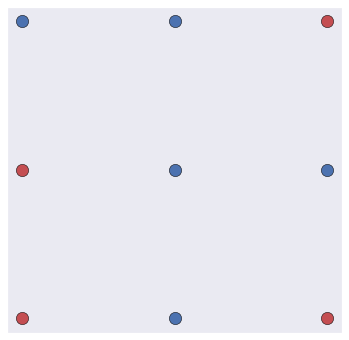

In [159]:
L = 3
N = L**2
s = random_infected(N, 4)
plot(N, s)
mod_states, states = simulate_epidemy(N, L, s, 0.5, 0.5, n_iter=10**4)

In [102]:
generate_gif(mod_states)

<img src="mygif2.gif" width="400" align="center">

### Plot da proporção

In [9]:
L = 100
N = L**2
s = random_infected(N, 4)
plot(N, s)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f3a4720d1f0> (for post_execute):


KeyboardInterrupt: 

Não há mais infectados. Iteração:  47


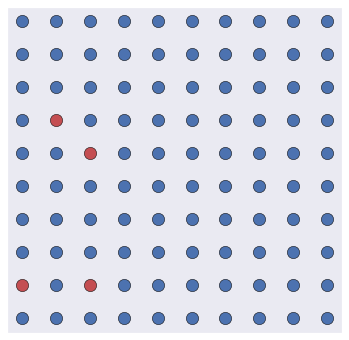

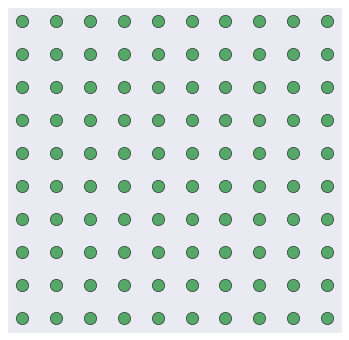

In [165]:
L = 10
N = L**2
s = random_infected(N, 4)
plot(N, s)
mod_states, states = simulate_epidemy(N, L, s, 0.5, 0.1, n_iter=10**4)
plot(N, s)

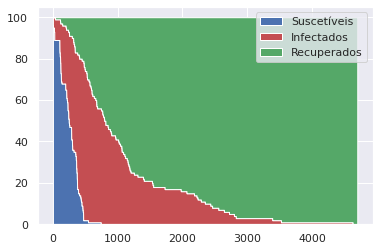

In [166]:
y0, y1, y2, x = histogram(states)
plt.stackplot(x,y0,y1,y2, colors=["b","r","g"])
plt.legend(["Suscetíveis","Infectados","Recuperados"])

In [1]:
plt.plot(x,y0/N, color='b')
plt.plot(x,y1/N, color='r')
plt.plot(x,y2/N, color='g')
plt.legend(["Suscetíveis","Infectados","Recuperados"])

NameError: name 'plt' is not defined

Obs.:
* Limitado: não simula vacinação, óbitos, reinfecção... Mas já dá uma boa ideia


# OFF

In [131]:
L = 150
N = L**2
s = random_infected(N, 20)
s

array([0, 0, 0, ..., 0, 0, 0])

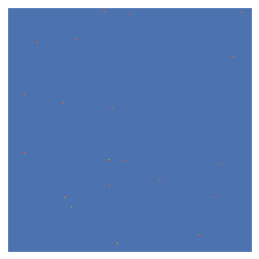

In [132]:
plot_map(s, L)

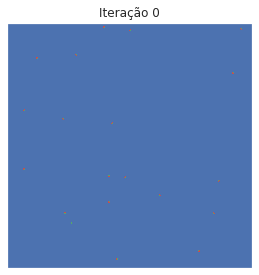

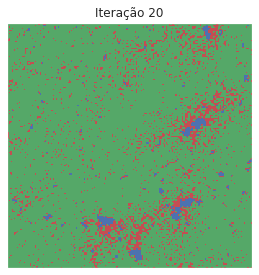

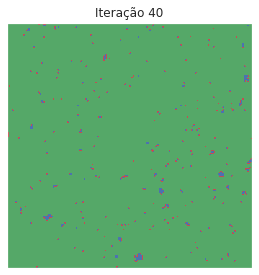

Não há mais infectados. Iteração:  56


In [133]:
y0, y1, y2, x = simulate_epidemy(N, L, s, 0.6, 0.2, n_iter=10**4, print_states=True)

In [144]:
def sum_different(a,b):
    """
    Soma os arrays a e b não simétricos
    
    Parâmetros:
        a,b: arrays
    Retornos:
        c = a + b
    """
    if len(a) < len(b):
        c = b.copy()
        c[:len(a)] += a
    else:
        c = a.copy()
        c[:len(b)] += b

    return c

def simulate(L, pc, pr, s=None, qtd=5):
    """
    Simula vários modelos SIR e retorna a média deles 
    """
    # Parâmetros
    N = L**2
    if (s is None):
        s = random_infected(N, 20)
    
    # Vetores para guardar
    suscp_total = np.zeros(1)
    infec_total = np.zeros(1)
    recup_total = np.zeros(1)
    for i in range(qtd):
        print("Rodada "+str(i))
        s0 = s.copy()
        sus, inf, rec, _ = simulate_epidemy(N, L, s0, pc, pr, n_iter=10**4)
        suscp_total = sum_different(suscp_total, sus)
        infec_total = sum_different(infec_total, inf)
        recup_total = sum_different(recup_total, rec)
    factor = 1/qtd
    
    suscp_total = np.array(suscp_total) * factor
    infec_total = np.array(infec_total) * factor
    recup_total = np.array(recup_total) * factor
    
    return suscp_total,infec_total,recup_total

In [145]:
y0, y1, y2 = simulate(L, s=None, pc=0.6, pr=0.2)

Rodada 0
Iteração 0
Iteração 20
Iteração 40
Iteração 60
Não há mais infectados. Iteração:  63
Rodada 1
Iteração 0
Iteração 20
Iteração 40
Iteração 60
Não há mais infectados. Iteração:  66
Rodada 2
Iteração 0
Iteração 20
Iteração 40
Iteração 60
Não há mais infectados. Iteração:  74
Rodada 3
Iteração 0
Iteração 20
Iteração 40
Não há mais infectados. Iteração:  56
Rodada 4
Iteração 0
Iteração 20
Iteração 40
Não há mais infectados. Iteração:  59


/home/arthur/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


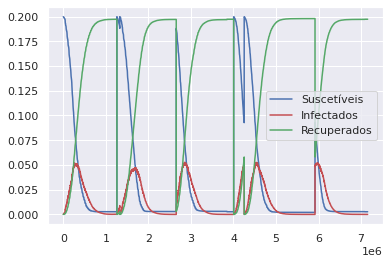

In [146]:
plt.plot(np.array(y0)/N, color='b')
plt.plot(np.array(y1)/N, color='r')
plt.plot(np.array(y2)/N, color='g')
plt.legend(["Suscetíveis","Infectados","Recuperados"])

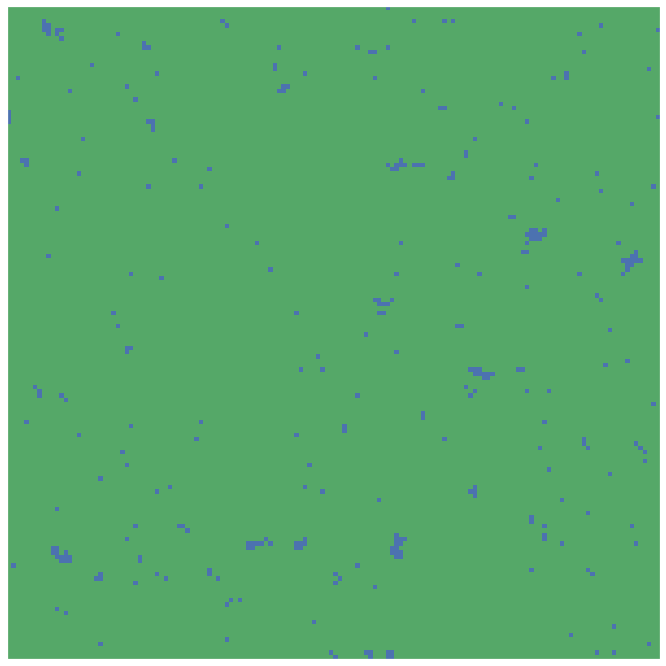

In [94]:
plot_map(s, L)

In [ ]:


filenames = []
for index, y in enumerate(coordinates_lists):
    # plot charts
    plt.bar(x, y)
    plt.ylim(0,80)
    
    # create file name and append it to a list
    filename = f'gif/{index}.png'
    filenames.append(filename)
    
    # repeat last frame
    if (index == len(coordinates_lists)-1):
        for i in range(15):
            filenames.append(filename)
            
    # save frame
    plt.savefig(filename)
    plt.close()

# Remove files
for filename in set(filenames):
    os.remove(filename)

In [69]:
Path("gif").rmdir()

In [47]:
s = random_infected(N, 1)
s

array([1, 0, 0, 0, 0, 0, 0, 0, 0])

In [71]:
N = L**2
s = random_epidemy_state(N)
s

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [72]:
simulate_epidemy(N, L, s, 0.5, 0.5)

8 recuperado
9 recuperado
22 contaminado por  12
23 contaminado por  13
15 contaminado por  14
4 contaminado por  14
25 contaminado por  15
5 contaminado por  15
16 recuperado
19 recuperado
20 contaminado por  21
23 recuperado
25 recuperado
26 recuperado
27 recuperado
31 recuperado
33 recuperado
34 recuperado
36 contaminado por  35
46 contaminado por  36
38 recuperado
30 contaminado por  40
41 recuperado
42 recuperado
45 contaminado por  46
47 recuperado
39 contaminado por  49
51 contaminado por  50
60 contaminado por  50
52 contaminado por  51
61 contaminado por  51
53 recuperado
44 contaminado por  54
56 recuperado
61 recuperado
63 recuperado
67 recuperado
71 recuperado
72 recuperado
77 contaminado por  76
75 contaminado por  76
66 contaminado por  76
79 contaminado por  78
89 contaminado por  79
69 contaminado por  79
82 contaminado por  81
83 contaminado por  82
95 contaminado por  85
84 contaminado por  85
96 contaminado por  86
88 recuperado
80 contaminado por  89
90 recuperado
3

In [28]:
viz = neighbours(N,np.sqrt(N))
viz

array([[1, 3, 2, 6],
       [2, 4, 0, 7],
       [0, 5, 1, 8],
       [4, 6, 5, 0],
       [5, 7, 3, 1],
       [3, 8, 4, 2],
       [7, 0, 8, 3],
       [8, 1, 6, 4],
       [6, 2, 7, 5]])